In [253]:
import nltk
import numpy as np
from sklearn.utils import shuffle
from nltk.corpus import stopwords, brown
from torch.utils.data import TensorDataset, DataLoader
nltk.download('stopwords')
nltk.download('brown')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [254]:
import pandas as pd

df = pd.read_csv('/home/dotronghiep/Documents/Datasets/Social_Listening/DataLabel.csv', header=None)
df.head(10)

,0,1,2
0,1,0,impossible to stop basically means russia is n...
1,2,0,indeed. may russia soil then selves in terror ...
2,3,0,"goodnight family, thanks to everyone for your ..."
3,4,0,keep adding more sanctionsfastest way to get r...
4,5,0,russia does not get to rape ukraine in order t...
5,6,1,its already done de facto. east ukraineand cri...
6,7,1,russia takes most of sievierodonetsk city in e...
7,8,0,biden says us to send ukraine 'advanced rocket...
8,9,1,just in - biden us to send ukraine advanced ro...
9,10,0,why do you suppose i do not understand that. i...


In [255]:
X_row = df.iloc[:, 2].values
y = df.iloc[:, 1].values

In [256]:
# Xác định số lượng mẫu của mỗi lớp
class_0_count = np.sum(y == 0)
class_1_count = np.sum(y == 1)
print(class_0_count,class_1_count)

4108 1663


In [257]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_row, y, test_size=0.2, random_state=42, stratify=y)

# Train the model

In [258]:
print(len(X_train))

4616


In [259]:
print(len(y_train))

4616


In [260]:
# lấy danh sách stopword
stop = set(stopwords.words('english'))
# stop = ()
brown_words = set(word for word in brown.words() if word.lower() not in stop)|{"biden",
                                                                               "ukraine","kiev","kyiv","zelensky", "ukrainian", "ukrainians",
                                                                               "putin","kremlin", "russia", "russian", "russians",
                                                                               "not", "no", "nor", "against", "never", "nobody", "none", "nowhere"}

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

In [261]:
def lemma(text):
    words = tokenizer.tokenize(text)
    cleaned_words = [lemmatizer.lemmatize(word, pos='v') for word in words if word in brown_words]
    return cleaned_words


# Loại bỏ stop words từ mỗi văn bản trong danh sách X
X_cleaned = [lemma(text) for text in X_train]
X_full = [lemma(text) for text in X_row]

In [262]:
X_cleaned[:10]

[['ukraine', 'every', 'right', 'attack', 'russia', 'point'],
 ['real', 'men', 'defend', 'country', 'people', 'respect'],
 ['well',
  'honest',
  'russian',
  'visit',
  'board',
  'quite',
  'time',
  'russia',
  'start',
  'military',
  'build',
  'ukraine',
  'border',
  'last',
  'year',
  'call',
  'journalist'],
 ['poor',
  'russian',
  'regime',
  'world',
  'say',
  'no',
  'brutal',
  'invasion',
  'play',
  'victim',
  'get',
  'ukraine'],
 ['definitely', 'arm', 'ukraine', 'teeth', 'keep', 'russia'],
 ['legitimate',
  'security',
  'concern',
  'already',
  'countries',
  'members',
  'military',
  'base',
  'nuclear',
  'capability',
  'wipe',
  'russia',
  'map',
  'ukraine',
  'make',
  'zero',
  'difference',
  'putin',
  'know',
  'join',
  'could',
  'not',
  'invade',
  'point'],
 ['ukraine',
  'shut',
  'listen',
  'russia',
  'like',
  'shut',
  'listen',
  'us',
  'argue',
  'otherwise',
  'accept',
  'kind',
  'absurd',
  'prevalent',
  'among',
  'riddle',
  'cat',

In [263]:
import torch
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

In [264]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [265]:
max_length = max(len(sentence) for sentence in X_cleaned)
max_length

36

In [266]:
model = Word2Vec(X_full, 
                 vector_size=100, 
                 window=9, 
                 min_count=5, 
                 workers=8, 
                 epochs=50)
vocabulary = model.wv.index_to_key
print(f"Vocabulary size: {len(vocabulary)}")

Vocabulary size: 2000


In [267]:
# Tìm từ gần nhất 
similar_words = model.wv.most_similar("putin")
for word, score in similar_words:
    print(f"{word}: {score:.4f}")

madness: 0.4468
dictator: 0.4134
tire: 0.3820
damn: 0.3767
lion: 0.3699
everyone: 0.3677
aggressor: 0.3633
dictatorship: 0.3598
prison: 0.3513
murderous: 0.3484


In [268]:
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence

def vectorize(X, y, model=model):
    X_vectors = []
    y_vectors = []
    # Chuyển từng từ trong mỗi câu thành vector biểu diễn và thêm padding
    for sentence, label in zip(X, y):
        if len(sentence) < 5:
            continue

        sentence_vectors = []
        for i, word in enumerate(sentence):
            # Kiểm tra xem từ đó có trong từ vựng của mô hình Word2Vec hay không
            if i > 35:
                break
            if word in model.wv:
                word_vector = model.wv[word]
                sentence_vectors.append(word_vector)
            else:
                pass

        # Thêm padding cho câu để độ dài của mỗi câu là 35
        while len(sentence_vectors) <= 35:
            sentence_vectors.append(np.zeros((100,)))  # Sử dụng vector zeros cho padding

        # Chuyển danh sách các vector thành một tensor
        sentence_tensor = torch.tensor(sentence_vectors)
        # Thêm câu đã được padding vào danh sách X_vectors
        X_vectors.append(sentence_tensor)
        y_vectors.append(label)


    # Chuyển danh sách X_vectors thành một tensor
    X_padded = np.array(X_vectors)
    y_padded = np.array(y_vectors)
    return X_padded, y_padded
# In ra kích thước của X_padded
X_input, y_input = vectorize(X_cleaned, y_train)
print(X_input.shape)
print(y_input.shape)


(4437, 36, 100)
(4437,)


In [293]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # Khởi tạo hidden state và cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Đưa đầu vào qua LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Lấy output của lớp cuối cùng
        out = self.dropout(out)
        out = self.fc1(out[:, -1, :])
        # out = self.dropout(out)
        # out = self.relu(out)
        # out = self.fc2(out)
        return out.squeeze(1)

# Định nghĩa các siêu tham số
input_size = 100  # Kích thước của vectơ biểu diễn từ
hidden_size = 16  # Kích thước của hidden state trong LSTM
num_layers = 1  # Số lớp LSTM xếp chồng lên nhau
num_classes = 2  # Số lớp đầu ra
num_epochs = 200  # Số epoch
lr = 0.005
batch_size = 128

In [294]:
def train_lstm(X_input, y_input, num_epochs=num_epochs):    
    # Khởi tạo mô hình
    lstm = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)
    lstm.to(device)

    X_train, X_valid, y_train, y_valid = train_test_split(X_input, y_input, test_size=0.2, stratify=y_input)

    # Xác định số lượng mẫu của mỗi lớp
    class_0_count = np.sum(y_train == 0)
    class_1_count = np.sum(y_train == 1)
    # Tính toán số lượng mẫu cần thêm vào mỗi lớp để làm cho số lượng mẫu của hai lớp bằng nhau
    samples_to_add = max(class_0_count, class_1_count) - min(class_0_count, class_1_count)

    # Lấy mẫu ngẫu nhiên từ các mẫu hiện có trong lớp ít mẫu để tạo ra số lượng mẫu cần thiết và thêm vào tập train
    if class_0_count < class_1_count:
        X_train_class_0 = X_train[y_train == 0]
        y_train_class_0 = y_train[y_train == 0]
        additional_indices = np.random.choice(range(class_0_count), samples_to_add)
        X_train_additional = X_train_class_0[additional_indices]
        y_train_additional = y_train_class_0[additional_indices]
        X_train = np.concatenate((X_train, X_train_additional))
        y_train = np.concatenate((y_train, y_train_additional))
    else:
        X_train_class_1 = X_train[y_train == 1]
        y_train_class_1 = y_train[y_train == 1]
        additional_indices = np.random.choice(range(class_1_count), samples_to_add)
        X_train_additional = X_train_class_1[additional_indices]
        y_train_additional = y_train_class_1[additional_indices]
        X_train = np.concatenate((X_train, X_train_additional))
        y_train = np.concatenate((y_train, y_train_additional))

    # Trộn lại dữ liệu để đảm bảo tính ngẫu nhiên
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train).to(device)
    y_valid = torch.tensor(y_valid).to(device)

    # Tạo DataLoader cho dữ liệu train và validation
    train_dataset = TensorDataset(X_train, y_train)

    valid_dataset = TensorDataset(X_valid, y_valid)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Vòng lặp huấn luyện
    losses_train = []
    losses_valid = []
    accuracies = []
    for epoch in range(1, num_epochs + 1):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Huấn luyện
        lstm.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = lstm(X_batch)
            loss = criterion(outputs, y_batch.float())
            loss.backward()
            optimizer.step()

        # In ra loss sau mỗi 5 eclass_0_count = np.sum(predicted_labels == 0)
        if epoch % 10 == 0:

            # Đánh giá mô hình trên tập validation
            lstm.eval()
            with torch.no_grad():
                # for X_batch, y_batch in valid_loader:
                outputs_train = lstm(X_train)
                loss_train = criterion(outputs_train, y_train.float())
                losses_train.append(loss_train.item())
                print(f"Epoch {epoch}, Loss train: {loss_train.item()}")

                outputs_valid = lstm(X_valid)
                loss_valid = criterion(outputs_valid, y_valid.float())
                losses_valid.append(loss_valid.item())
                print(f"Epoch {epoch}, Loss validate: {loss_valid.item()}")

            # _, predicted = torch.max(outputs_valid, 1)
            predicted = torch.round(torch.sigmoid(outputs_valid))
            predicted_labels = predicted.cpu().numpy()
            true_labels = y_valid.cpu().numpy()
            accuracy = accuracy_score(true_labels, predicted_labels)
            accuracies.append(accuracy)
            precision = precision_score(true_labels, predicted_labels)
            recall = recall_score(true_labels, predicted_labels)
            f1 = f1_score(true_labels, predicted_labels)

            print("Accuracy:", accuracy)
            print("Precision:", precision)
            print("Recall:", recall)
            print("F1 Score:", f1)

            print("=========================================")
    return lstm, losses_train, losses_valid, accuracies

In [295]:
lstm, losses_train, losses_valid, accuracies = train_lstm(X_input, y_input)

Epoch 10, Loss train: 0.6931641101837158
Epoch 10, Loss validate: 0.6962860822677612
Accuracy: 0.2905405405405405
Precision: 0.2905405405405405
Recall: 1.0
F1 Score: 0.450261780104712
Epoch 20, Loss train: 0.6931477189064026
Epoch 20, Loss validate: 0.6947035193443298
Accuracy: 0.2905405405405405
Precision: 0.2905405405405405
Recall: 1.0
F1 Score: 0.450261780104712
Epoch 30, Loss train: 0.6931027173995972
Epoch 30, Loss validate: 0.6937397718429565
Accuracy: 0.2905405405405405
Precision: 0.2905405405405405
Recall: 1.0
F1 Score: 0.450261780104712
Epoch 40, Loss train: 0.6931390166282654
Epoch 40, Loss validate: 0.6946070790290833
Accuracy: 0.2905405405405405
Precision: 0.2905405405405405
Recall: 1.0
F1 Score: 0.450261780104712
Epoch 50, Loss train: 0.6926734447479248
Epoch 50, Loss validate: 0.6951506733894348
Accuracy: 0.2905405405405405
Precision: 0.2905405405405405
Recall: 1.0
F1 Score: 0.450261780104712
Epoch 60, Loss train: 0.560926079750061
Epoch 60, Loss validate: 0.6858197450637

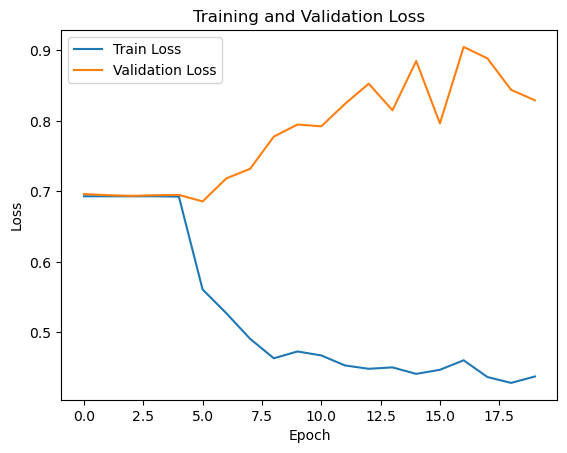

In [296]:
plt.plot(losses_train, label='Train Loss')
plt.plot(losses_valid, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Test

In [297]:
X_test_cleaned = [lemma(text) for text in X_test]
test_max_length = max(len(sentence) for sentence in X_test_cleaned)
print(test_max_length)

31


In [298]:
X_test_vector, y_test_vector = vectorize(X_test_cleaned, y_test)
print(X_test_vector.shape)
print(y_test_vector.shape)

(1104, 36, 100)
(1104,)


In [299]:
outputs_test = lstm(torch.tensor(X_test_vector, dtype=torch.float32).to(device))

predicted_label = torch.round(torch.sigmoid(outputs_test))
predicted_labels = predicted_label.cpu().detach().numpy()
true_labels = y_test_vector
accuracy = accuracy_score(true_labels, predicted_labels)
accuracies.append(accuracy)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.677536231884058
Precision: 0.3793103448275862
Recall: 0.17133956386292834
F1 Score: 0.23605150214592271


In [300]:
# Convert the predicted labels to a numpy array
predicted_labels = np.array(predicted_labels, dtype=int)

# Count the number of occurrences of each class
class_counts = np.bincount(predicted_labels)

# Print the class counts
for class_label, count in enumerate(class_counts):
    print(f"Class {class_label}: {count}")


Class 0: 959
Class 1: 145
